### T-test 

In [1]:
# from __future__ import print_function, division
from tqdm import tqdm_notebook as tqdm
import numpy as np
import os
import sys
import pandas as pd
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
from keras_bert import load_vocabulary
import matplotlib.pyplot as plt

from scipy.stats import t
from scipy import stats
    
from methods.preprocessing import Preprocess
from methods.baseline import Baseline
from methods.retrieval import Retrieval
from approaches.deepQL_topics import run as deepql_topics_run

import _pickle as pickle

from methods.evaluation import Evaluation, EvaluationPrecision, EvaluationRecall, EvaluationFscore

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html

In [ ]:
DOMAIN = "openoffice"
PREPROCESSING = 'bert'
TOKEN = 'bert'
normalized = os.path.join('data/normalized', DOMAIN, '{}.csv'.format(DOMAIN))
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)
for TEST in [['deepQL_topics', 'deepTL_topics']]:
    recall = {}
    for MODEL in TEST:
        RANK =  os.path.join('data/processed', DOMAIN, TOKEN, 'exported_rank_{}_1000.txt'.format(MODEL))
        evaluate = Evaluation(0)
        evaluate.evaluate(RANK)
        report = evaluate.get_recalls()
        recall[MODEL] = report
recall

In [63]:
position = '0'
recall_at = '1'
y_train = np.array(range(len(recall['deepQL_topics']['{} - recall_at_{}'.format(position, recall_at)])))
y_test = np.array(range(len(recall['deepTL_topics']['{} - recall_at_{}'.format(position, recall_at)])))
A_score = np.array(recall['deepQL_topics']['{} - recall_at_{}'.format(position, recall_at)])
B_score = np.array(recall['deepTL_topics']['{} - recall_at_{}'.format(position, recall_at)])


y = np.concatenate([y_train, y_test])

(array([6364.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0., 5393.]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 <a list of 15 Patch objects>)

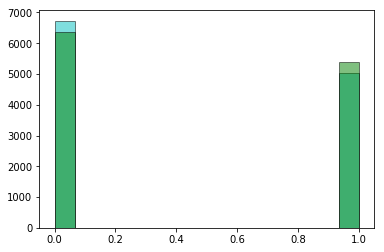

In [64]:
plt.hist(A_score, bins=15, color='c', edgecolor='k', alpha=0.5)
plt.hist(B_score, bins=15, color='g', edgecolor='k', alpha=0.5)

In [65]:
_, Pvalue = stats.ttest_rel(A_score, B_score)
# Compouter diferrence value between scores 
Dvalue = round(np.mean(A_score - B_score), 2)
print("Diference score", Dvalue)
print("P-value", Pvalue)
print("reject null hypothesis", Pvalue < 0.05)

Diference score -0.03
P-value 1.2209045123694927e-14
reject null hypothesis True


In [66]:
_, Pvalue = stats.wilcoxon(A_score, B_score)
# Compouter diferrence value between scores 
Dvalue = round(np.mean(A_score - B_score), 2)
print("Diference score", Dvalue)
print("P-value", Pvalue)
print("reject null hypothesis", Pvalue < 0.05)

Diference score -0.03
P-value 1.3127710449836274e-14
reject null hypothesis True


In [67]:
dup_method_A = [x for x in A_score if x == 1.0]
dup_method_B = [x for x in B_score if x == 1.0]

qtd_dup_method_A = len(dup_method_A)
qtd_dup_method_B = len(dup_method_B)
qtd_non_dup_method_A = len(A_score) - qtd_dup_method_A
qtd_non_dup_method_B = len(B_score) - qtd_dup_method_B

# A_score_table = [qtd_non_dup_method_A / len(A_score), qtd_dup_method_A / len(A_score)]
# B_score_table = [qtd_non_dup_method_B / len(B_score), qtd_dup_method_B / len(B_score)]

A_score_table = np.array([qtd_dup_method_A, qtd_non_dup_method_A], float)
B_score_table = np.array([qtd_dup_method_B, qtd_non_dup_method_B], float)

A_score_table, B_score_table

(array([5026., 6731.]), array([5393., 6364.]))

In [68]:
_, Pvalue = stats.fisher_exact([A_score_table, B_score_table], alternative='two-sided')
# Compouter diferrence value between scores 
Dvalue = round(np.mean(A_score - B_score), 2)
print("Diference score", Dvalue)
print("P-value", Pvalue)
print("reject null hypothesis", Pvalue < 0.05)

Diference score -0.03
P-value 1.5457214673558431e-06
reject null hypothesis True


In [69]:
_, Pvalue = stats.chisquare(A_score_table, B_score_table)
# Compouter diferrence value between scores 
Dvalue = round(np.mean(A_score - B_score), 2)
print("Diference score", Dvalue)
print("P-value", Pvalue)
print("reject null hypothesis", Pvalue < 0.05)

Diference score -0.03
P-value 1.101544712566169e-11
reject null hypothesis True


## Calculate statistical results for retrieval

In [18]:
method_dict = {
    'baseline' : 'DMS',
    'baseline_dwen' : 'DWEN',
    'deepQL_topics' : 'SiameseQAT-A',
    'deepQL_topics_trainable' : 'SiameseQAT-W',
    'deepQL_weights' : 'SiameseQA-W',
    'deepQL_no_trainable' : 'SiameseQA-A',
    'deepQL_trainable' : 'SiameseQA-W',
    'deepTL' : 'SiameseTA',
    'deepTL_topics' : 'SiameseTAT'
}

In [40]:
methods = ['deepQL_topics_trainable', 'deepQL_topics', 'deepQL_no_trainable', 'deepQL_trainable', 'deepTL', 'deepTL_topics']
methods_with_bases = ['deepQL_topics_trainable', 'deepQL_topics', 'deepQL_no_trainable', 'deepQL_trainable', 'deepTL', 'deepTL_topics', 'baseline', 'baseline_dwen']

combinations = []
for method_a in methods:
    for method_b in methods_with_bases:
        if method_a != method_b:
            combinations.append([method_a, method_b])

combinations

[['deepQL_topics_trainable', 'deepQL_topics'],
 ['deepQL_topics_trainable', 'deepQL_no_trainable'],
 ['deepQL_topics_trainable', 'deepQL_trainable'],
 ['deepQL_topics_trainable', 'deepTL'],
 ['deepQL_topics_trainable', 'deepTL_topics'],
 ['deepQL_topics_trainable', 'baseline'],
 ['deepQL_topics_trainable', 'baseline_dwen'],
 ['deepQL_topics', 'deepQL_topics_trainable'],
 ['deepQL_topics', 'deepQL_no_trainable'],
 ['deepQL_topics', 'deepQL_trainable'],
 ['deepQL_topics', 'deepTL'],
 ['deepQL_topics', 'deepTL_topics'],
 ['deepQL_topics', 'baseline'],
 ['deepQL_topics', 'baseline_dwen'],
 ['deepQL_no_trainable', 'deepQL_topics_trainable'],
 ['deepQL_no_trainable', 'deepQL_topics'],
 ['deepQL_no_trainable', 'deepQL_trainable'],
 ['deepQL_no_trainable', 'deepTL'],
 ['deepQL_no_trainable', 'deepTL_topics'],
 ['deepQL_no_trainable', 'baseline'],
 ['deepQL_no_trainable', 'baseline_dwen'],
 ['deepQL_trainable', 'deepQL_topics_trainable'],
 ['deepQL_trainable', 'deepQL_topics'],
 ['deepQL_traina

In [41]:
%%time

# DOMAIN = "openoffice"
PREPROCESSING = 'bert'
TOKEN = 'bert'
normalized = os.path.join('data/normalized', DOMAIN, '{}.csv'.format(DOMAIN))
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)

result = []

# [['deepQL_topics', 'deepQL_topics_trainable'],
#                 ['deepQL_topics', 'deepTL_topics'], ['deepQL_topics', 'deepTL'], ['deepQL_topics', 'deepQL_no_trainable'], 
#                 ['deepQL_topics', 'deepQL_trainable'], ['deepQL_topics', 'baseline'], ['deepQL_topics', 'baseline_dwen']]


def get_evaluation(position, recall_at, method_a, method_b, recall):
    y_train = np.array(range(len(recall[method_a]['{} - recall_at_{}'.format(position, recall_at)])))
    y_test = np.array(range(len(recall[method_b]['{} - recall_at_{}'.format(position, recall_at)])))
    A_score = np.array(recall[method_a]['{} - recall_at_{}'.format(position, recall_at)])
    B_score = np.array(recall[method_b]['{} - recall_at_{}'.format(position, recall_at)])


    y = np.concatenate([y_train, y_test])

    Dvalue = round(np.mean(A_score - B_score), 2)
    gain = abs(round((np.mean(B_score) - np.mean(A_score)) /  np.mean(B_score) * 100.0, 2))

    # T-test
    _, Pvalue = stats.ttest_rel(A_score, B_score)
    result.append([method_dict[method_a], method_dict[method_b], recall_at, Pvalue < 0.05, Pvalue, Dvalue, gain, 't-test', DOMAIN])

for DOMAIN in ['eclipse', 'netbeans', 'openoffice']:
    
    for TEST in combinations:
        recall = {}
        for MODEL in TEST:
            RANK =  os.path.join('data/processed', DOMAIN, TOKEN, 'exported_rank_{}_1000.txt'.format(MODEL))
            evaluate = Evaluation(0)
            evaluate.evaluate(RANK)
            report = evaluate.get_recalls()
            recall[MODEL] = report
        
        
        method_a, method_b = TEST
        
        get_evaluation(0, '1', method_a, method_b, recall)
        get_evaluation(1, '5', method_a, method_b, recall)
        get_evaluation(2, '10', method_a, method_b, recall)
        get_evaluation(3, '15', method_a, method_b, recall)
        get_evaluation(4, '20', method_a, method_b, recall)
        get_evaluation(5, '25', method_a, method_b, recall)
            
        
df_recall = pd.DataFrame(result, columns=['A', 'B', 'recall_at', 'significant', 'p_value', 'd_value', 'gain', 'test', 'domain'])

CPU times: user 10min 18s, sys: 1.95 s, total: 10min 20s
Wall time: 10min 16s


In [46]:
df_recall[(df_recall['domain'] == 'eclipse') & (df_recall['recall_at'] == '1')]

,A,B,recall_at,significant,p_value,d_value,gain,test,domain
0,SiameseQAT-W,SiameseQAT-A,1,True,3.160717e-02,-0.01,1.42,t-test,eclipse
6,SiameseQAT-W,SiameseQA-A,1,True,3.346992e-20,0.03,6.77,t-test,eclipse
12,SiameseQAT-W,SiameseQA-W,1,True,8.067736e-26,0.03,7.70,t-test,eclipse
18,SiameseQAT-W,SiameseTA,1,True,7.427615e-32,0.03,8.81,t-test,eclipse
24,SiameseQAT-W,SiameseTAT,1,True,1.285142e-02,0.01,1.69,t-test,eclipse
30,SiameseQAT-W,DMS,1,True,0.000000e+00,0.17,74.59,t-test,eclipse
36,SiameseQAT-W,DWEN,1,True,0.000000e+00,0.29,266.86,t-test,eclipse
42,SiameseQAT-A,SiameseQAT-W,1,True,3.160717e-02,0.01,1.44,t-test,eclipse
48,SiameseQAT-A,SiameseQA-A,1,True,1.438362e-29,0.03,8.31,t-test,eclipse
54,SiameseQAT-A,SiameseQA-W,1,True,9.614422e-37,0.03,9.26,t-test,eclipse


In [54]:
df_recall[(df_recall['domain'] == 'eclipse') & (df_recall['recall_at'] == '5')]

,A,B,recall_at,significant,p_value,d_value,gain,test,domain
1,SiameseQAT-W,SiameseQAT-A,5,True,3.059200e-03,-0.01,1.44,t-test,eclipse
7,SiameseQAT-W,SiameseQA-A,5,True,3.352471e-27,0.03,5.84,t-test,eclipse
13,SiameseQAT-W,SiameseQA-W,5,True,3.162333e-37,0.04,6.91,t-test,eclipse
19,SiameseQAT-W,SiameseTA,5,True,2.129811e-37,0.04,7.01,t-test,eclipse
25,SiameseQAT-W,SiameseTAT,5,False,2.023125e-01,0.00,0.64,t-test,eclipse
31,SiameseQAT-W,DMS,5,True,0.000000e+00,0.19,49.62,t-test,eclipse
37,SiameseQAT-W,DWEN,5,True,0.000000e+00,0.44,329.35,t-test,eclipse
43,SiameseQAT-A,SiameseQAT-W,5,True,3.059200e-03,0.01,1.46,t-test,eclipse
49,SiameseQAT-A,SiameseQA-A,5,True,3.348008e-42,0.04,7.39,t-test,eclipse
55,SiameseQAT-A,SiameseQA-W,5,True,2.859427e-55,0.05,8.47,t-test,eclipse


In [48]:
df_recall[(df_recall['domain'] == 'netbeans') & (df_recall['recall_at'] == '1')]

,A,B,recall_at,significant,p_value,d_value,gain,test,domain
252,SiameseQAT-W,SiameseQAT-A,1,False,2.117887e-01,-0.00,0.66,t-test,netbeans
258,SiameseQAT-W,SiameseQA-A,1,True,7.553410e-18,0.02,4.82,t-test,netbeans
264,SiameseQAT-W,SiameseQA-W,1,True,3.466626e-14,0.02,4.21,t-test,netbeans
270,SiameseQAT-W,SiameseTA,1,True,1.416968e-28,0.03,6.50,t-test,netbeans
276,SiameseQAT-W,SiameseTAT,1,True,8.493695e-05,0.01,2.14,t-test,netbeans
282,SiameseQAT-W,DMS,1,True,0.000000e+00,0.15,50.17,t-test,netbeans
288,SiameseQAT-W,DWEN,1,True,0.000000e+00,0.29,170.64,t-test,netbeans
294,SiameseQAT-A,SiameseQAT-W,1,False,2.117887e-01,0.00,0.66,t-test,netbeans
300,SiameseQAT-A,SiameseQA-A,1,True,2.344678e-21,0.02,5.51,t-test,netbeans
306,SiameseQAT-A,SiameseQA-W,1,True,8.159786e-18,0.02,4.91,t-test,netbeans


In [55]:
df_recall[(df_recall['domain'] == 'netbeans') & (df_recall['recall_at'] == '5')]

,A,B,recall_at,significant,p_value,d_value,gain,test,domain
253,SiameseQAT-W,SiameseQAT-A,5,True,2.139470e-02,-0.01,0.94,t-test,netbeans
259,SiameseQAT-W,SiameseQA-A,5,True,2.708681e-14,0.02,3.30,t-test,netbeans
265,SiameseQAT-W,SiameseQA-W,5,True,1.470364e-28,0.03,4.88,t-test,netbeans
271,SiameseQAT-W,SiameseTA,5,True,2.623231e-31,0.03,5.27,t-test,netbeans
277,SiameseQAT-W,SiameseTAT,5,True,1.452148e-03,0.01,1.32,t-test,netbeans
283,SiameseQAT-W,DMS,5,True,0.000000e+00,0.15,33.04,t-test,netbeans
289,SiameseQAT-W,DWEN,5,True,0.000000e+00,0.40,198.04,t-test,netbeans
295,SiameseQAT-A,SiameseQAT-W,5,True,2.139470e-02,0.01,0.95,t-test,netbeans
301,SiameseQAT-A,SiameseQA-A,5,True,3.957896e-22,0.03,4.28,t-test,netbeans
307,SiameseQAT-A,SiameseQA-W,5,True,3.426761e-39,0.03,5.88,t-test,netbeans


In [49]:
df_recall[(df_recall['domain'] == 'openoffice') & (df_recall['recall_at'] == '1')]

,A,B,recall_at,significant,p_value,d_value,gain,test,domain
504,SiameseQAT-W,SiameseQAT-A,1,True,1.404013e-03,0.01,2.94,t-test,openoffice
510,SiameseQAT-W,SiameseQA-A,1,True,7.617753e-06,0.02,4.15,t-test,openoffice
516,SiameseQAT-W,SiameseQA-W,1,True,2.302702e-12,0.03,6.72,t-test,openoffice
522,SiameseQAT-W,SiameseTA,1,True,2.898475e-04,-0.01,3.25,t-test,openoffice
528,SiameseQAT-W,SiameseTAT,1,True,4.363856e-06,-0.02,4.06,t-test,openoffice
534,SiameseQAT-W,DMS,1,True,0.000000e+00,0.22,103.06,t-test,openoffice
540,SiameseQAT-W,DWEN,1,True,0.000000e+00,0.32,272.23,t-test,openoffice
546,SiameseQAT-A,SiameseQAT-W,1,True,1.404013e-03,-0.01,2.86,t-test,openoffice
552,SiameseQAT-A,SiameseQA-A,1,False,2.095097e-01,0.00,1.17,t-test,openoffice
558,SiameseQAT-A,SiameseQA-W,1,True,1.371363e-04,0.02,3.67,t-test,openoffice


In [56]:
df_recall[(df_recall['domain'] == 'openoffice') & (df_recall['recall_at'] == '5')]

,A,B,recall_at,significant,p_value,d_value,gain,test,domain
505,SiameseQAT-W,SiameseQAT-A,5,True,1.514569e-03,0.01,2.19,t-test,openoffice
511,SiameseQAT-W,SiameseQA-A,5,True,9.883350e-08,0.02,3.69,t-test,openoffice
517,SiameseQAT-W,SiameseQA-W,5,True,2.391100e-13,0.03,5.20,t-test,openoffice
523,SiameseQAT-W,SiameseTA,5,True,4.483666e-04,-0.01,2.33,t-test,openoffice
529,SiameseQAT-W,SiameseTAT,5,True,6.609059e-08,-0.02,3.53,t-test,openoffice
535,SiameseQAT-W,DMS,5,True,0.000000e+00,0.27,81.43,t-test,openoffice
541,SiameseQAT-W,DWEN,5,True,0.000000e+00,0.44,283.51,t-test,openoffice
547,SiameseQAT-A,SiameseQAT-W,5,True,1.514569e-03,-0.01,2.14,t-test,openoffice
553,SiameseQAT-A,SiameseQA-A,5,True,3.614872e-02,0.01,1.47,t-test,openoffice
559,SiameseQAT-A,SiameseQA-W,5,True,4.210696e-05,0.02,2.94,t-test,openoffice


## Calculate statistical results for classification

In [5]:
def load_result(name):
    with open(os.path.join(DIR,'{}.pkl'.format(name)), 'rb') as f:
        return pickle.load(f)

In [50]:
# DOMAIN = "openoffice"
PREPROCESSING = 'bert'
TOKEN = 'bert'
normalized = os.path.join('data/normalized', DOMAIN, '{}.csv'.format(DOMAIN))
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)

result = []

for DOMAIN in ['eclipse', 'netbeans', 'openoffice']: 

    for TEST in combinations:
        acc = {}
        for MODEL in TEST:
            
            name = '{}_1000_classification'.format(MODEL)
            report = load_result(name)
            
            acc[MODEL] = report['acc']

        method_a, method_b = TEST
        y_train = np.array(range(len(acc[method_a])))
        y_test = np.array(range(len(acc[method_b])))
        A_score = np.array(acc[method_a])
        B_score = np.array(acc[method_b])
            
        y = np.concatenate([y_train, y_test])

        Dvalue = round(np.mean(A_score - B_score), 2)
        gain = abs(round((np.mean(B_score) - np.mean(A_score)) /  np.mean(B_score) * 100.0, 2))

        # T-test
        _, Pvalue = stats.mstats.ttest_ind(A_score, B_score)
        result.append([method_dict[method_a], method_dict[method_b], Pvalue < 0.05, Pvalue, Dvalue, gain, 't-test', DOMAIN])
        
df = pd.DataFrame(result, columns=['A', 'B', 'significant', 'p_value', 'd_value', 'gain', 'test', 'domain'])

In [51]:
df[df['domain'] == 'eclipse']

,A,B,significant,p_value,d_value,gain,test,domain
0,SiameseQAT-W,SiameseQAT-A,True,9.558379e-239,-0.04,4.63,t-test,eclipse
1,SiameseQAT-W,SiameseQA-A,True,5.740104e-112,-0.03,3.32,t-test,eclipse
2,SiameseQAT-W,SiameseQA-W,True,2.174678e-99,-0.03,3.14,t-test,eclipse
3,SiameseQAT-W,SiameseTA,True,1.291294e-49,-0.02,2.27,t-test,eclipse
4,SiameseQAT-W,SiameseTAT,True,2.501759e-228,-0.04,4.54,t-test,eclipse
5,SiameseQAT-W,DMS,True,1.304374e-02,-0.00,0.40,t-test,eclipse
6,SiameseQAT-W,DWEN,True,0.000000e+00,0.21,30.13,t-test,eclipse
7,SiameseQAT-A,SiameseQAT-W,True,9.558379e-239,0.04,4.86,t-test,eclipse
8,SiameseQAT-A,SiameseQA-A,True,1.125425e-26,0.01,1.37,t-test,eclipse
9,SiameseQAT-A,SiameseQA-W,True,2.668848e-33,0.01,1.56,t-test,eclipse


In [52]:
df[df['domain'] == 'netbeans']

,A,B,significant,p_value,d_value,gain,test,domain
42,SiameseQAT-W,SiameseQAT-A,True,9.558379e-239,-0.04,4.63,t-test,netbeans
43,SiameseQAT-W,SiameseQA-A,True,5.740104e-112,-0.03,3.32,t-test,netbeans
44,SiameseQAT-W,SiameseQA-W,True,2.174678e-99,-0.03,3.14,t-test,netbeans
45,SiameseQAT-W,SiameseTA,True,1.291294e-49,-0.02,2.27,t-test,netbeans
46,SiameseQAT-W,SiameseTAT,True,2.501759e-228,-0.04,4.54,t-test,netbeans
47,SiameseQAT-W,DMS,True,1.304374e-02,-0.00,0.40,t-test,netbeans
48,SiameseQAT-W,DWEN,True,0.000000e+00,0.21,30.13,t-test,netbeans
49,SiameseQAT-A,SiameseQAT-W,True,9.558379e-239,0.04,4.86,t-test,netbeans
50,SiameseQAT-A,SiameseQA-A,True,1.125425e-26,0.01,1.37,t-test,netbeans
51,SiameseQAT-A,SiameseQA-W,True,2.668848e-33,0.01,1.56,t-test,netbeans


In [53]:
df[df['domain'] == 'openoffice']

,A,B,significant,p_value,d_value,gain,test,domain
84,SiameseQAT-W,SiameseQAT-A,True,9.558379e-239,-0.04,4.63,t-test,openoffice
85,SiameseQAT-W,SiameseQA-A,True,5.740104e-112,-0.03,3.32,t-test,openoffice
86,SiameseQAT-W,SiameseQA-W,True,2.174678e-99,-0.03,3.14,t-test,openoffice
87,SiameseQAT-W,SiameseTA,True,1.291294e-49,-0.02,2.27,t-test,openoffice
88,SiameseQAT-W,SiameseTAT,True,2.501759e-228,-0.04,4.54,t-test,openoffice
89,SiameseQAT-W,DMS,True,1.304374e-02,-0.00,0.40,t-test,openoffice
90,SiameseQAT-W,DWEN,True,0.000000e+00,0.21,30.13,t-test,openoffice
91,SiameseQAT-A,SiameseQAT-W,True,9.558379e-239,0.04,4.86,t-test,openoffice
92,SiameseQAT-A,SiameseQA-A,True,1.125425e-26,0.01,1.37,t-test,openoffice
93,SiameseQAT-A,SiameseQA-W,True,2.668848e-33,0.01,1.56,t-test,openoffice
